In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nb_005 import *

# Pascal

## Setup

In [3]:
PATH = Path('data/pascal')
JPEG_PATH = PATH/'VOCdevkit'/'VOC2007'/'JPEGImages'

In [4]:
import json
trn_j = json.load((PATH / 'pascal_train2007.json').open())

In [5]:
classes = {o['id']:o['name'] for o in trn_j['categories']}
filenames = {o['id']:JPEG_PATH/o['file_name'] for o in trn_j['images']}
annotations = [{'img_id': o['image_id'], 
                'class': classes[o['category_id']], 
                'bbox':o['bbox']} for o in trn_j['annotations'] if not o['ignore']]

In [6]:
len(annotations)

6301

In [7]:
annot_by_img = collections.defaultdict(list)
for annot in annotations:
    annot_by_img[annot['img_id']].append({'class': annot['class'], 'bbox': annot['bbox']})

In [8]:
len(annot_by_img)

2501

First, let's do build a model finding the biggest bbox.

In [9]:
biggest_bb = {}
for id in filenames.keys():
    size,best = 0,0
    for i,o in enumerate(annot_by_img[id]):
        o_sz = o['bbox'][2] * o['bbox'][3]
        if size < o_sz:
            size,best = o_sz,i
    biggest_bb[id] = annot_by_img[id][best]

In [10]:
ids = np.array(list(filenames.keys()))
ids = np.random.permutation(ids)
split = int(len(filenames) * 0.2)
train_fns = [filenames[i] for i in ids[split:]]
valid_fns = [filenames[i] for i in ids[:split]]

In [11]:
bboxes = {}
for i in filenames.keys():
    bb = biggest_bb[i]['bbox']
    bboxes[i] = [[bb[1],bb[0]], [bb[3]+bb[1], bb[2]+bb[0]]]

train_bbs = [bboxes[i] for i in ids[split:]]
valid_bbs = [bboxes[i] for i in ids[:split]]

In [12]:
@dataclass
class CoordTargetDataset(Dataset):
    x_fns:List[Path]; bbs:List[List[float]]
    def __post_init__(self): assert len(self.x_fns)==len(self.bbs)
    def __repr__(self): return f'{type(self).__name__} of len {len(self.x_fns)}'
    def __len__(self): return len(self.x_fns)
    def __getitem__(self, i): return open_image(self.x_fns[i]), self.bbs[i]

In [13]:
train_ds = CoordTargetDataset(train_fns, train_bbs)
valid_ds = CoordTargetDataset(valid_fns, valid_bbs)

In [14]:
from matplotlib import patches, patheffects
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def bb_hw(a): return np.array([a[0][1],a[0][0],a[1][1]-a[0][1],a[1][0]-a[0][0]])
    
def show_img_bb(img, bb, ax=None):
    if not ax: fig,ax = plt.subplots()
    ax.imshow(img.numpy().transpose(1,2,0))
    draw_rect(ax, bb_hw(bb))

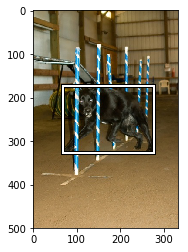

In [15]:
show_img_bb(*train_ds[0])

In [16]:
train_bbs[0]

[[173, 69], [328, 277]]

In [17]:
biggest_bb[ids[split]]

{'class': 'dog', 'bbox': [69, 173, 208, 155]}

Check that it's the biggest bbox indeed.

In [18]:
annot_by_img[ids[split]]

[{'class': 'dog', 'bbox': [69, 173, 208, 155]},
 {'class': 'chair', 'bbox': [286, 161, 30, 37]}]

In [ ]:
data = DataBunch.create(train_ds, valid_ds, bs, num_workers=0, train_tfm=train_tfms, valid_tfm=valid_tfms, size=sz)

## Model

We take a pretrained resnet34 with a custom head.

In [19]:
from torchvision.models import resnet34

In [20]:
arch = resnet34

In [26]:
def create_skeleton(model, cut):
    layers = list(model.children())
    if cut != 0: layers = layers[:-cut]
    return nn.Sequential(*layers)

In [27]:
model = create_skeleton(arch(), 2)

In [28]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [ ]:
x,y = ne

Once 5a works...

In [ ]:
TfmY = IntEnum('TfmY', 'No Pixel Mask Coord BBox')

class TfmDataset(Dataset):
    def __init__(self, ds:Dataset, tfms:Collection[Callable]=None, tfm_y:TfmY=TfmY.No, **kwargs):
        self.ds,self.tfms,self.tfm_y,self.kwargs = ds,tfms,tfm_y,kwargs

    def __len__(self): return len(self.ds)

    def __getitem__(self,idx):
        x,y = self.ds[idx]
        if self.tfms is not None:
            tfm = apply_tfms(self.tfms)
            coord = (self.tfm_y == TfmY.Coord or self.tfm_y == TfmY.BBox)
            if coord: y = torch.cat([torch.Tensor([x.size(1),x.size(2)]).float()[None], y],0)
            x = tfm(x, **self.kwargs)
            if self.tfm_y != TfmY.No and y is not None:
                seg = self.tfm_y == TfmY.Mask
                y = tfm(y, segmentation=seg, is_coord=coord, **self.kwargs)[1:]
                if self.tfm_y == TfmY.BBox:
                    y = torch.Tensor([[min(y[:,0]),min(y[:,1])], [max(y[:,0]),max(y[:,1])]])
        return x,y